In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import warnings

from pathlib import Path

if not Path("images").exists():
    Path("images").mkdir(parents=True)
warnings.filterwarnings('ignore')

In [70]:
exp_full = pd.read_csv('../experiments/Altruism_RMAI experiment-table-run-2.csv', skiprows=[0, 1, 2, 3, 4, 5])
step_col = exp_full.pop("[step]")
exp_full.insert(1, "step", step_col)
exp_full = exp_full.rename(columns={"[run number]": "run-number"}).sort_values(by=['run-number', 'step'])
exp_full.head(10)

,run-number,step,occupation-var,reproduction-var,initial-patch-harshness,prob-gain-resource,stride-length,agent-move-cost,energy-gain,altruism-resource-threshold,initial-patch-resource,initial-population,initial-agent-energy,altruism-prob,repeat-diffusion,count altruism-agents,count greedy-agents
7,1,0,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,52,48
18,1,1,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,104,96
29,1,2,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,208,192
38,1,3,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,208,192
48,1,4,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,208,192
56,1,5,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,416,384
65,1,6,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,416,384
77,1,7,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,416,384
88,1,8,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,682,768
98,1,9,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,691,768


In [71]:
COLS_TO_OMIT = ['run-number', 'step', 'count altruism-agents', 'count greedy-agents']

summary = exp_full.describe().T
summary

,count,mean,std,min,25%,50%,75%,max
run-number,3291717.0,16327.853071,9451.748526,1.00,8148.00,16296.0,24490.0,32805.0
step,3291717.0,49.942034,29.165334,0.00,25.00,50.0,75.0,100.0
occupation-var,3291717.0,0.497377,0.326052,0.10,0.10,0.5,0.9,0.9
reproduction-var,3291717.0,0.500286,0.326581,0.10,0.10,0.5,0.9,0.9
initial-patch-harshness,3291717.0,24.901723,16.323003,5.00,5.00,25.0,45.0,45.0
prob-gain-resource,3291717.0,0.400018,0.163308,0.20,0.20,0.4,0.6,0.6
stride-length,3291717.0,0.136583,0.121199,0.01,0.01,0.1,0.3,0.3
agent-move-cost,3291717.0,9.998554,4.081523,5.00,5.00,10.0,15.0,15.0
energy-gain,3291717.0,58.339903,31.176714,25.00,25.00,50.0,100.0,100.0
altruism-resource-threshold,3291717.0,49.960829,24.503117,20.00,20.00,50.0,80.0,80.0


## Filter down to end states


In [72]:
exp = exp_full[exp_full["step"] == exp_full.groupby(['run-number'])['step'].transform('max')]
exp.head(10)

,run-number,step,occupation-var,reproduction-var,initial-patch-harshness,prob-gain-resource,stride-length,agent-move-cost,energy-gain,altruism-resource-threshold,initial-patch-resource,initial-population,initial-agent-energy,altruism-prob,repeat-diffusion,count altruism-agents,count greedy-agents
1091,1,100,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,2680,5345
1053,2,100,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,2384,5717
1076,3,100,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,2877,5212
1080,4,100,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,2586,5147
1024,5,100,0.1,0.1,5,0.2,0.01,5,25,20,50,100,100,0.5,2,3048,4761
994,6,100,0.1,0.1,5,0.2,0.01,5,25,50,50,100,100,0.5,2,0,6224
962,7,100,0.1,0.1,5,0.2,0.01,5,25,50,50,100,100,0.5,2,0,6651
1015,8,100,0.1,0.1,5,0.2,0.01,5,25,50,50,100,100,0.5,2,0,7170
943,9,100,0.1,0.1,5,0.2,0.01,5,25,50,50,100,100,0.5,2,0,5534
924,10,100,0.1,0.1,5,0.2,0.01,5,25,50,50,100,100,0.5,2,0,5503


In [73]:
exp = exp[exp['step'] == 100].drop(columns=['step'])


In [74]:
varying_inputs = [i for i in summary.index if summary.loc[i]['min'] != summary.loc[i]['max'] and i not in COLS_TO_OMIT]
varying_inputs

['occupation-var',
 'reproduction-var',
 'initial-patch-harshness',
 'prob-gain-resource',
 'stride-length',
 'agent-move-cost',
 'energy-gain',
 'altruism-resource-threshold']

In [78]:
exp['altruism_ratio'] = exp['count altruism-agents'] / (exp['count altruism-agents'] + exp['count greedy-agents'])
exp = exp.drop(columns=['count altruism-agents', 'count greedy-agents']).set_index('run-number')
y = exp.pop('altruism_ratio')
X = exp[varying_inputs]


KeyError: 'count altruism-agents'

In [79]:
def run_regression_analysis(X, y):
        # Standardizing the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Setting up cross-validation (e.g., 5-fold cross-validation)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    # Evaluating the model's performance with cross-validation
    model = LinearRegression()
    cv_scores = cross_validate(model, X_scaled, y, cv=cv, scoring='neg_mean_squared_error', return_estimator=True)
    
    # Printing cross-validation results
    print(f"Mean Squared Error for each fold: {-cv_scores['test_score']}")
    print(f"Average Mean Squared Error: {-np.mean(cv_scores['test_score'])}")
    
    # Optionally, training the model on the entire dataset for interpretation
    model.fit(X_scaled, y)
    
    # Analyzing feature importance (coefficients)
    coefficients = model.coef_
    features = X.columns
    
    # Sorting the coefficients by their absolute values but keeping the sign
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]
    sorted_features = features[sorted_indices]
    sorted_coefficients = coefficients[sorted_indices]
    
    print("Feature Coefficients from Most to Least Important after Normalization:")
    for feature, coef in zip(sorted_features, sorted_coefficients):
        print(f"{feature}: {coef}")
    
    # Plotting the sorted coefficients for visual comparison
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_coefficients)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title("Sorted Feature Coefficients in Linear Regression after Normalization")
    plt.gca().invert_yaxis()
    plt.show()

Mean Squared Error for each fold: [0.01069828 0.01087882 0.01047338 0.01055568 0.01104735]
Average Mean Squared Error: 0.010730702889253499
Feature Coefficients from Most to Least Important after Normalization:
altruism-resource-threshold: -0.15013066418233526
reproduction-var: 0.004391969620109876
occupation-var: 0.0026559168687743198
initial-patch-harshness: 0.0010660683840244003
prob-gain-resource: 0.0010194401441944194
stride-length: 0.0005830445558728394
agent-move-cost: -0.0003812802594209091
energy-gain: 0.00020732348705115836


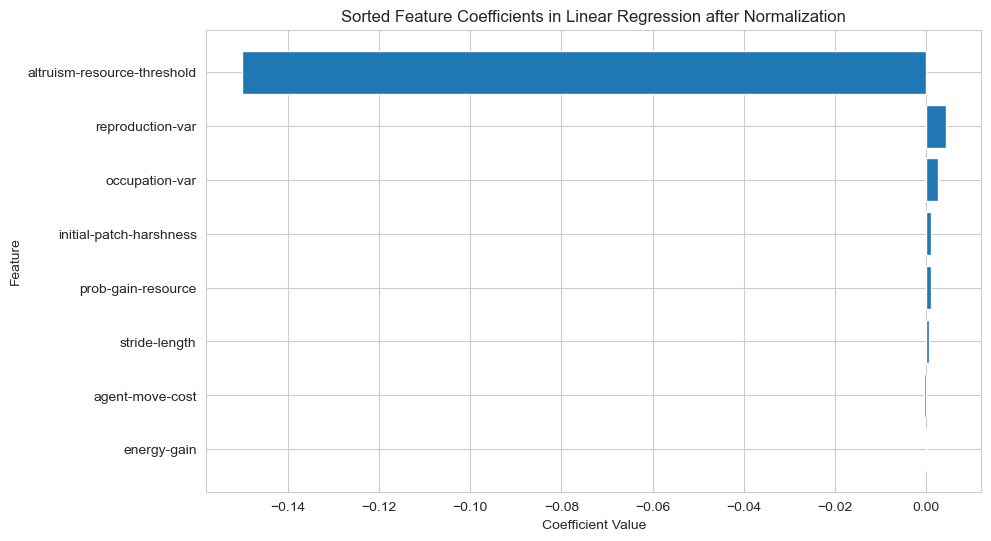

In [80]:
run_regression_analysis(X, y)

#### Filter out runs where altruists die and run again

Mean Squared Error for each fold: [0.00977185 0.00933099 0.00819633 0.00843175 0.00831364]
Average Mean Squared Error: 0.008808912387140298
Feature Coefficients from Most to Least Important after Normalization:
reproduction-var: 0.013001791295815392
occupation-var: 0.010028025611787342
initial-patch-harshness: 0.004595125518441289
prob-gain-resource: 0.0031653497648979866
stride-length: 0.0010722030868761613
agent-move-cost: -0.0010697239842130362
energy-gain: 0.0007561643823898573
altruism-resource-threshold: 0.0


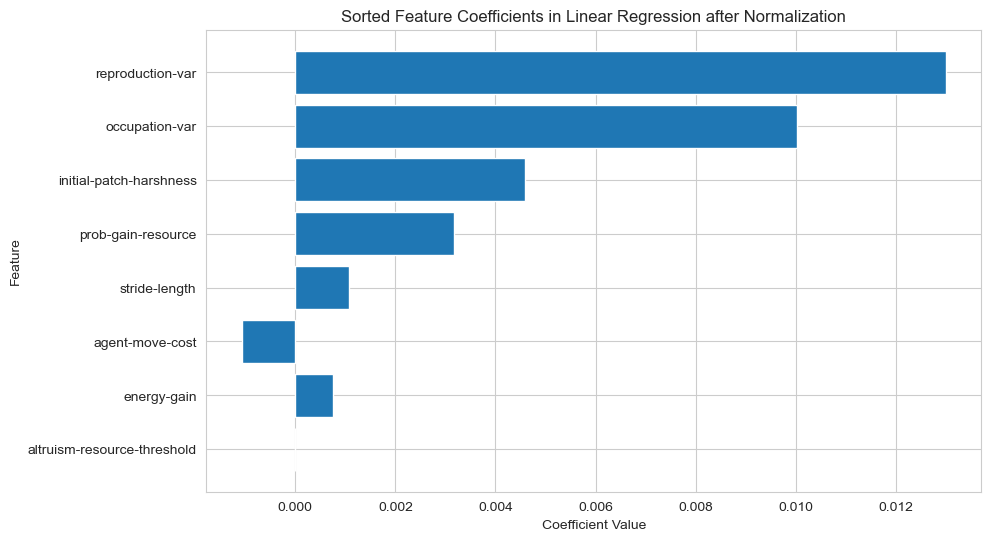

In [81]:
X = X[y != 0]
y = y[y != 0]

run_regression_analysis(X, y)